In [10]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *
from data.training import *
from sc import *

In [11]:
df = pd.read_json('data/dbdump_testdb.jobs_v5.json')
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# df = df[df['company'].str.contains('ecco')]
# df['description'].unique().tolist()
# df[df['description'].str.contains('contattato')]['description'].unique().tolist()

/var/folders/l9/p2tp5gr9171dtk7txwfptt100000gn/T/ipykernel_24460/2113680643.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [12]:
df = pd.read_csv('data/job_description_seed_dataset_improved_context.csv')
df['len'] = df.apply(lambda x: len(x['text']), axis=1)
# df.sort_values('len', ascending=False, inplace=True)
# df[df['inclusive phrasing'] == 'NO'].head(100)['text'].iloc[14]
df.sort_values(by=['len'],ascending=False).head()['text'].to_list()
_map = {
    'YES': 'INCLUSIVO',
    'NO': 'NON INCLUSIVO'
}
df['label'] = df.apply(lambda x: _map[x['inclusive phrasing']], axis=1)
# df[['text','label']].values.tolist()

#TEXT_SEED_v0()
# df[(df['len'] >= 700) & (df['len'] <= 10000)]['text'].unique()

In [13]:
df = pd.read_csv('data/raw_data_finetune_train.csv')
df['text_JOB_value'] = df.apply(lambda x: x['text_JOB_value'] if isinstance(x['text_JOB_value'],str) else "", axis=1)
df['text_ADJ_value'] = df.apply(lambda x: x['text_ADJ_value'] if isinstance(x['text_ADJ_value'],str) else "", axis=1)
df['text_VERB_value'] = df.apply(lambda x: x['text_VERB_value'] if isinstance(x['text_VERB_value'],str) else "", axis=1)
df_jobs = df[df['text_JOB_value'] != ""]
df_adj = df[df['text_ADJ_value'] != ""]
df_verb = df[df['text_VERB_value'] != ""]
df_other = df[(df['text_JOB_value'] == "") & (df['text_ADJ_value'] == "") & (df['text_VERB_value'] == "")]
tot = len(df)
# tot, len(df_jobs)/tot, len(df_adj)/tot, len(df_verb)/tot, len(df_other)/tot

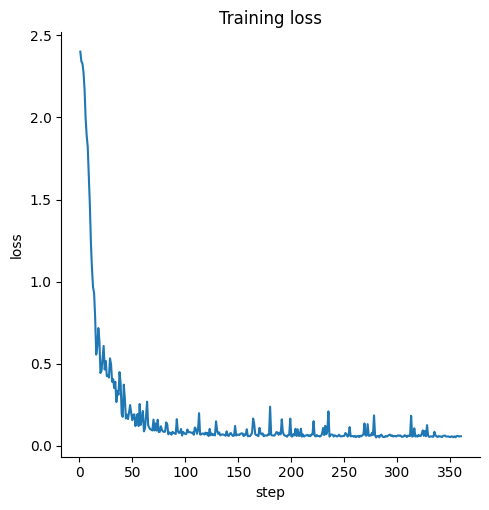

In [14]:
df_loss = pd.DataFrame({
    'step': [int(ln.split('	')[0]) for ln in TRAINING_LOSS.split('\n')],
    'loss': [float(ln.split('	')[1]) for ln in TRAINING_LOSS.split('\n')],
})
sns.relplot(data=df_loss, x='step', y='loss', kind='line')
plt.title('Training loss')
plt.show()

In [15]:
df = pd.read_csv(sc_csv_name("qwen2", False, False))
df = fix_df(df)
df = fix_df_model_response(df, 'qwen2')
df['response'].unique().tolist()

Fixed 0.0, 0 rows


['NON INCLUSIVO', 'INCLUSIVO']

llama3
Fixed 0.0, 3 rows
mistral
Fixed 0.02, 171 rows
gemma2
Fixed 0.0, 7 rows
qwen2
Fixed 0.0, 0 rows


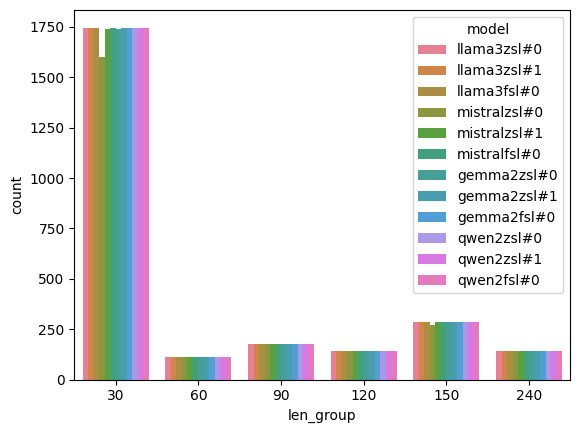

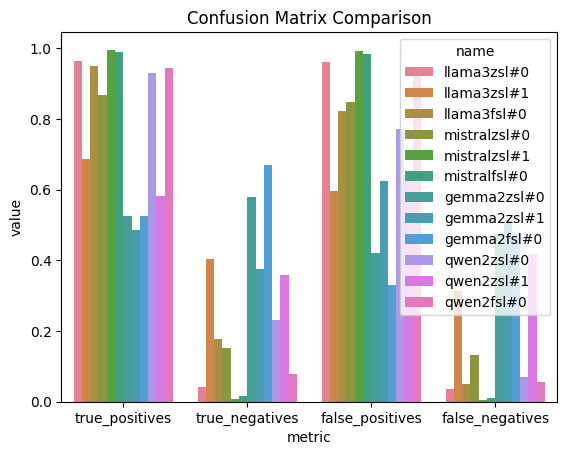

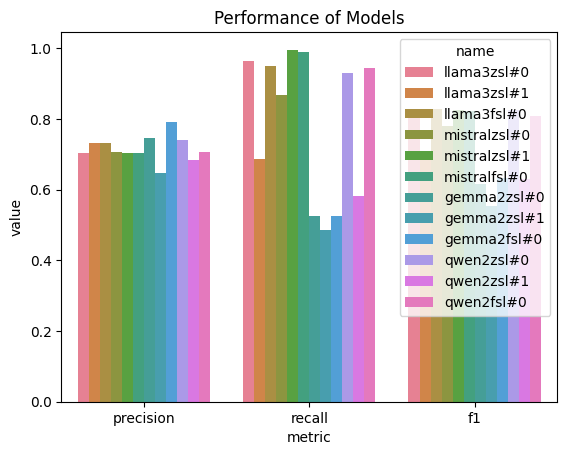

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:364: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


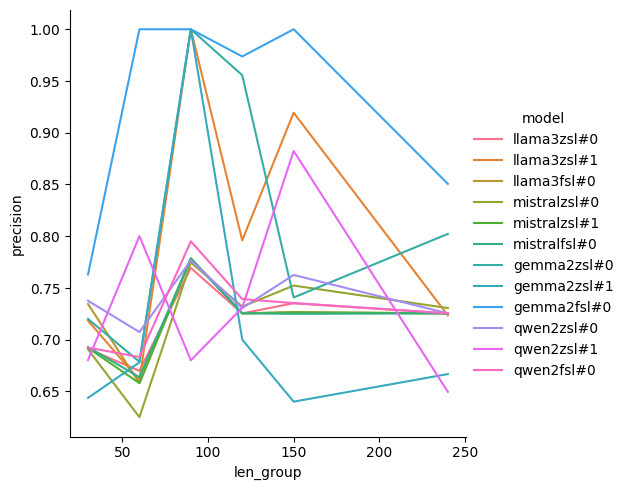

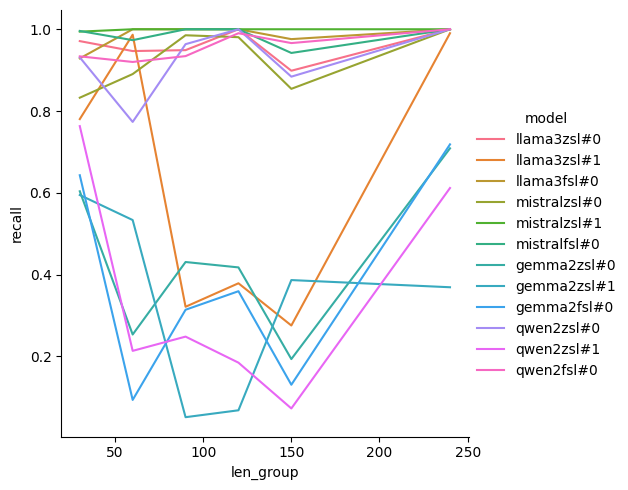

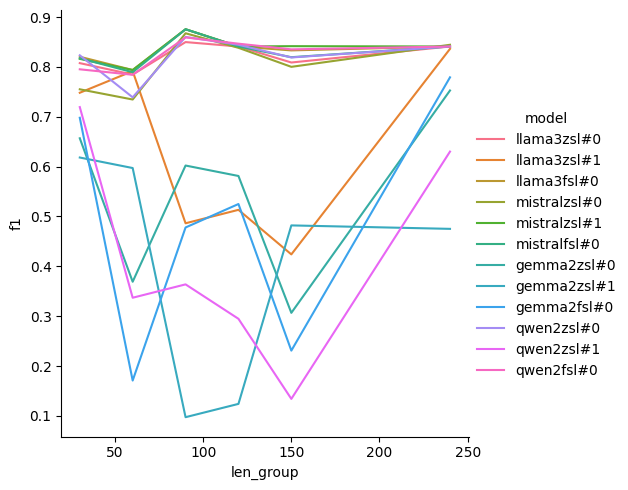

In [19]:
dfs_all = []
dfs_by_len = []
# df = pd.read_csv(f'results/{model}_split-long-v0.csv')
for model in [
# "phi3-finetuned",
"llama3",
"mistral",
"gemma2",
"qwen2",
]:
    print(model)
    try:
        df = pd.read_csv(sc_csv_name(model, False, False))
        df = fix_df(df)
        # df = count_contains(df, "response", "INCLUSIVO", True)
        # df = simple_fix_response(df)
        df = fix_df_model_response(df, model)
        # confusion_matrix(df)
        df = make_df_len(df)
        for p in df['prompt_id'].unique():
            df_ = df[df['prompt_id'] == p]
            dfs_all.append((df_,model+p))
            for l in df['len_group'].unique():
                df_l = df_[df_['len_group'] == l]
                dfs_by_len.append((df_l,f"{model+p}_{l}"))
    except Exception as e:
        print(model, e)

plot_len_groups(dfs_all)
df_all_metrics = metrics_of_dfs(dfs_all)
plot_compare_matrix(df_all_metrics)
plot_compare_performance_models(df_all_metrics)
df_len_metrics = metrics_of_dfs(dfs_by_len)
df_metrics_fix = fix_df_len_metrics(df_len_metrics)
plot_len_metrics(df_metrics_fix, "precision")
plot_len_metrics(df_metrics_fix, "recall")
plot_len_metrics(df_metrics_fix, "f1")

# plot_mult_metrics(df_metrics, [
#     "pred/gt_pos%",
#     "pred/gt_neg%",
#     ])

In [17]:
assert 1 == 2

AssertionError: 

In [ ]:
res_models_df = None

show_plots = True

model = 'phi3-finetuned'
prompt = 'zsl#0'

print(model)
df = pd.read_csv(f'results/{model}-eval-long-split-v0.csv')

if model == 'phi3-finetuned':
    df = df[~df['response'].str.contains('NOT IN TEST DATASET')]
df['text_id'] = df.apply(lambda x: x['text_id'] if x['text_id'][1] == '#' else "t" + x['text_id'][2:], axis=1)
df['text'] = df.apply(lambda x: DataGenerator.get(x['text_id'],
                                                # TEXT_JOB_TEST_v0,
                                                sc_test_texts(),
                                                    SUBS_JOBS_V0,
                                                    )['text'][0],
                    axis=1)
# df = df[df['prompt_id'].str.contains('cot')]

df_fix = fix_df(df, model, show_plot=show_plots)
df_prompt = df_fix[df_fix['prompt_id'] == prompt]
df_len = split_by_len(df_prompt, groups=40)
df_len

phi3-finetuned


TypeError: fix_df() got an unexpected keyword argument 'show_plot'

model
    count    %     df prompt_id           true
0  1833.0  1.0    raw     zsl#0      INCLUSIVO
0  1833.0  1.0  fixed     zsl#0      INCLUSIVO
0   774.0  1.0    raw     zsl#0  NON INCLUSIVO
0   774.0  1.0  fixed     zsl#0  NON INCLUSIVO


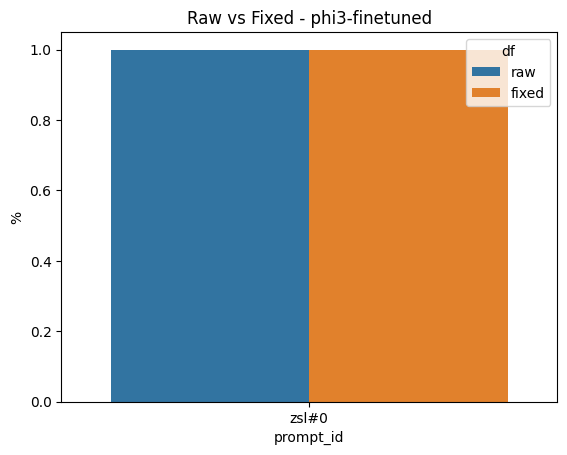

zsl#0
1420 1152 35


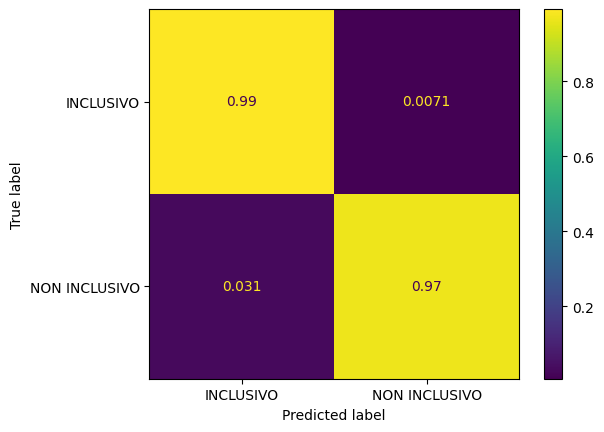

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


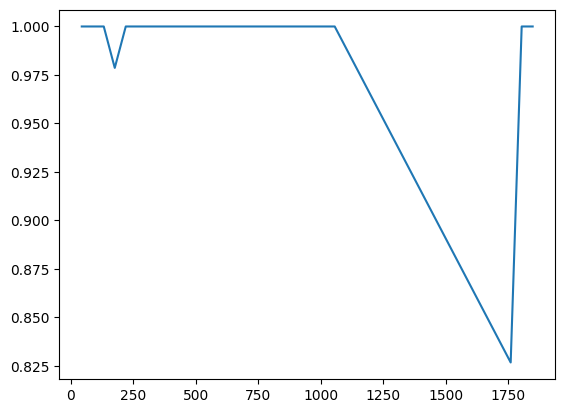

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:344: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


         name  pred/gt_pos%  pred/gt_neg%  precision  accuracy
0         all      1.006001      0.985788   0.986985  0.985807
0        jobs      1.019417      0.948718   0.977143  0.980282
0  adjectives      1.000000      1.000000   1.000000  1.000000
0      others      0.742857      9.000000   1.000000  0.742857


NameError: name 'show_plots' is not defined

In [ ]:

# print(df_fix['true'].value_counts())
# print(df_fix['response'].value_counts())

#for p in df_fix['prompt_id'].unique():

df_len = split_by_len(_df, groups=40)

if 'text_JOB_value' in _df.columns:
    df_jobs = _df[_df['text_JOB_value'] != ""]
    df_adj = _df[_df['text_ADJ_value'] != ""]
    if "text_VERB_value" in _df.columns:
        df_verb = _df[_df['text_VERB_value'] != ""]
        df_other = _df[(_df['text_JOB_value'] == "") & (_df['text_ADJ_value'] == "") & (_df['text_VERB_value'] == "")]
        print(len(df_jobs), len(df_adj), len(df_verb), len(df_other))
    else:
        df_other = _df[(_df['text_JOB_value'] == "") & (_df['text_ADJ_value'] == "")]
        print(len(df_jobs), len(df_adj), len(df_other))

# sns.countplot(data=df_jobs, x='true')
# plt.show()

confusion_matrix(_df)

analyze_len(df_len)

df_metrics = metrics_of_dfs([
    (_df, "all"),
    (df_jobs,"jobs"),
    (df_adj,"adjectives"),
    # (df_verb,"verbs"),
    (df_other,"others"),
])
print(df_metrics[['name','pred/gt_pos%','pred/gt_neg%','precision','accuracy']])
if show_plots:
    plot_metrics(df_metrics, "phi3-finetuned")

continue

all = metrics(_df)
all['name'] = 'all'
res_df = pd.DataFrame(all, index=[0])
all['name'] = model + " - " + p
if res_models_df is None:
    res_models_df = pd.DataFrame(all, index=[0])
else:
    res_models_df = pd.concat([res_models_df, pd.DataFrame(all, index=[0])])

for __df, nm in [
    (df_jobs,"jobs"),
    (df_adj,"adjectives"),
    (df_verb,"verbs"),
    (df_other,"others"),
] if 'text_JOB_value' in _df.columns else []:
    print(nm)
    if len(__df) == 0:
        continue
    _metrics = metrics(__df)
    _metrics['name'] = nm
    res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

# _metrics = metrics(isin(df_jobs, NEUTRALS))
# _metrics['name'] = 'neutrals'
# res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

# symbols = ['Ã',' e ',' o ','\*','/']
# for s in symbols:
#     _metrics = metrics(contains(df_jobs, [s]))
#     _metrics['name'] = s
#     res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

# _metrics = metrics(df_notjobs[df_notjobs['true'] == 'INCLUSIVO'])
# _metrics['name'] = 'notjob_inclusive'
# res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

# _metrics = metrics(df_notjobs[df_notjobs['true'] == 'NON INCLUSIVO'])
# _metrics['name'] = 'notjob_not_inclusive'
# res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

# _metrics = metrics(df_jobs[df_jobs['true'] == 'INCLUSIVO'])
# _metrics['name'] = 'job_inclusive'
# res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

# _metrics = metrics(df_jobs[df_jobs['true'] == 'NON INCLUSIVO'])
# _metrics['name'] = 'job_not_inclusive'
# res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

if show_plots:
    print(res_df)
    plot_metrics(res_df, f" - {model} - {p}")

# print('all')
# plot_metrics(res_models_df, "- All models")
# res_models_df